В качестве домашнего задания мы предлагаем вам решить задачу бинарной классификации на большом корпусе imdb рецензий на фильмы. Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/

Ваша задача в sklearn, используя один из алгоритмов, рассмотренных на паре, построить и обучить классификатор, посчитать метрики качества, построить ROC кривую и посчитайте величину ROC AUC. - 4 балла

Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели. - 3 балла

Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными sklearn метриками). - 3 балла

# Чтение данных

In [1]:
import os


BASE_PATH = os.path.join("aclImdb_v1", "aclImdb")
TEST_PATH = os.path.join(BASE_PATH, "test")
TRAIN_PATH = os.path.join(BASE_PATH, "train")

In [2]:
import pandas as pd


df_train = pd.DataFrame(columns=["filename", "text", "target"])

for path, _, filenames in os.walk(os.path.join(TRAIN_PATH, "pos")):
    for filename in filenames:
        with open(os.path.join(path, filename), "r", encoding="utf-8") as f:
            df_train = df_train.append(
                {
                    "filename": filename,
                    "text": f.read(),
                    "target": 1
                },
                ignore_index=True
            )

In [3]:
for path, _, filenames in os.walk(os.path.join(TRAIN_PATH, "neg")):
    for filename in filenames:
        with open(os.path.join(path, filename), "r", encoding="utf-8") as f:
            df_train = df_train.append(
                {
                    "filename": filename,
                    "text": f.read(),
                    "target": 0
                },
                ignore_index=True
            )

In [4]:
df_train.head()

,filename,text,target
0,0_9.txt,Bromwell High is a cartoon comedy. It ran at t...,1
1,10000_8.txt,Homelessness (or Houselessness as George Carli...,1
2,10001_10.txt,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,10002_7.txt,This is easily the most underrated film inn th...,1
4,10003_8.txt,This is not the typical Mel Brooks film. It wa...,1


In [5]:
df_train.sample(5)

,filename,text,target
9325,7143_10.txt,"""Holes"" is my all-time favorite movie! So far ...",1
19056,4651_3.txt,"Of course, ""Flatley"" is already not exactly th...",0
698,10629_10.txt,"Michigan, Edgar Allen Poe, a toaster, and a fr...",1
5470,3674_8.txt,With the sun shining brilliantly on a quiet Su...,1
15717,1646_1.txt,I like movies about morally corrupt characters...,0


In [6]:
df_test = pd.DataFrame(columns=["filename", "text", "target"])

for path, _, filenames in os.walk(os.path.join(TEST_PATH, "pos")):
    for filename in filenames:
        with open(os.path.join(path, filename), "r", encoding="utf-8") as f:
            df_test = df_test.append(
                {
                    "filename": filename,
                    "text": f.read(),
                    "target": 1
                },
                ignore_index=True
            )

In [7]:
for path, _, filenames in os.walk(os.path.join(TEST_PATH, "neg")):
    for filename in filenames:
        with open(os.path.join(path, filename), "r", encoding="utf-8") as f:
            df_test = df_test.append(
                {
                    "filename": filename,
                    "text": f.read(),
                    "target": 0
                },
                ignore_index=True
            )

In [8]:
df_test.sample(5)

,filename,text,target
18560,4204_1.txt,"I work in an office on weekends, and there is ...",0
22755,7981_4.txt,I recently was in a stage version of this play...,0
473,10426_8.txt,i LOVED THIS MOVIEE well i loved the romance p...,1
7467,5471_10.txt,I am from Texas and my family vacationed a cou...,1
23950,9056_4.txt,"Personally, I didn't really gain a whole lot f...",0


# Логистическая регрессия

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [21]:
vec = CountVectorizer()
X_train = vec.fit_transform(df_train["text"].values)
y_train = df_train["target"].values.astype("int32")
clf = LogisticRegression()
clf.fit(X_train, y_train)

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
X_test = vec.transform(df_test["text"].values)
pred = clf.predict(X_test)

# Метрики

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve

y_test = df_test["target"].values.astype("int32")
roc_auc_score(y_test, pred)

0.86672

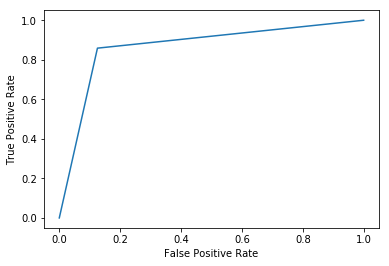

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [27]:
# скопировала из своей контрольной

def calc_tp_fn(y_true, y_pred, class_=1):
  tp = 0
  fn = 0
  fp = 0
  tn = 0
  for i, elem in enumerate(y_true):
    if elem == class_:
      if y_pred[i] == class_:
        tp += 1
      else:
        fn += 1
    else:
      if y_pred[i] == class_:
        fp += 1
      else:
        tn += 1
  return tp, tn, fp, fn


def precision(y_true, y_pred, class_=1):
  tp, _, fp, _ = calc_tp_fn(y_true, y_pred, class_)
  return tp / (tp + fp)

def recall(y_true, y_pred, class_=1):
  tp, _, fp, fn = calc_tp_fn(y_true, y_pred, class_)
  return tp / (tp + fn)

def fscore(y_true, y_pred, class_=1):
  prec = precision(y_true, y_pred, class_)
  rec = recall(y_true, y_pred, class_)
  return 2 * (prec * rec) / (prec + rec)

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision: {precision(y_test, pred):.4f} (sklearn: {precision_score(y_test, pred):.4f})")
print(f"Recall: {recall(y_test, pred):.4f} (sklearn: {recall_score(y_test, pred):.4f})")
print(f"F1-score: {fscore(y_test, pred):.4f} (sklearn: {f1_score(y_test, pred):.4f})")

Precision: 0.8726 (sklearn: 0.8726)
Recall: 0.8588 (sklearn: 0.8588)
F1-score: 0.8657 (sklearn: 0.8657)


# Предсказание вероятностей

In [31]:
probs = clf.predict_proba(X_test)
probs

array([[1.35209509e-02, 9.86479049e-01],
       [2.03953736e-04, 9.99796046e-01],
       [2.33701038e-02, 9.76629896e-01],
       ...,
       [1.00227516e-02, 9.89977248e-01],
       [9.30000094e-01, 6.99999064e-02],
       [4.40196680e-03, 9.95598033e-01]])

In [32]:
df_test["prob_pos"] = probs[:,1]

In [33]:
df_test.sample(5)

,filename,text,target,prob_pos
19901,5411_1.txt,"To be honest, the movie was SO HORRIBLE that I...",0,0.016590
14410,1171_1.txt,Old Ed was active back in the late 1950's He w...,0,0.964793
10579,8272_10.txt,I'm so happy I recorded this on VHS tape when ...,1,0.999901
23920,9029_4.txt,"Allegedly the ""true story"" of Juana de Castill...",0,0.000704
4921,317_10.txt,As I peruse through the hundreds of comments t...,1,0.999971


In [34]:
text_sorted = df_test.sort_values(by="prob_pos")["text"]

15 самых негативных:

In [36]:
for elem in text_sorted[:15]:
    print(elem, end="\n\n-----------------------------------------\n\n")

Snake Island is one of those films that, whilst one sits and watches its amazing level of stupidity, makes one wish the film camera had never been invented. The real reason why Plan 9 From Outer Space will hold onto its honoured title of Worst Film Of All Time for a while to come is not so much because of how bad it is. It is because of the fact that it is the most entertaining bad film you will ever see. Snake Island is the other kind of bad. Snake Island is just so bad that it is excruciating. A stupid premise combines with a script that was written by monkeys tapping one-key typewriters onto transparencies that were then overlapped in order to resemble dialogue to make the most obvious problems here. Filmed entirely on location in South Africa, the environments in which the film takes place are about the only element that can truthfully be considered well-realised. Many shots involving snakes consist of close-ups so surreal in appearance that one begins to wonder whether said snakes

15 самых позитивных:

In [37]:
for elem in text_sorted[-15:]:
    print(elem, end="\n\n-----------------------------------------\n\n")

Life is comprised of infinite possibilities; some known, others a mystery and destined to remain so. And what of the vast unknown, the realms beyond which knowledge has no established boundaries or parameters? Who is to say what exists or what is possible? Valid questions, all of which are raised and explored in the story of a particular individual's personal journey, a strange and dramatic odyssey that defies facts and logic, in `K-PAX,' directed by Iain Softley, and starring Kevin Spacey and Jeff Bridges. In the wake of an incident in New York's Central Station, a man named Prot (Spacey) is transported to a psychiatric hospital in Manhattan, where he is delivered into the care of Dr. Mark Powell (Bridges), who attempts to uncover the truth about his patient, who claims to be from the distant planet K-PAX. It quickly becomes a challenge for Dr. Powell, as Prot, with his calm, direct, forthcoming manner and a propensity for produce (he eats bananas peels and all, and Red Delicious Appl

(Негативные идут в порядке уменьшения "негативности", а позитивные – в порядке увеличения "позитивности", но никто же не просил как-либо упорядочивать, да и оценки модели – это так себе повод утверждать, что топ-1 строго позитивнее по мнению любого живого человека, чем топ-2)